# Small MNIST denoising autoencoder

## Table of contents
1. [Model definition and training](#Training)
1. [Saving model weights](#Saving-model-weights)
1. [Testing high resolution](#Testing-high-resolution)
1. [Saving test images](#Saving-test-images)

## Training

In [10]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, Lambda
from torchvision.datasets import MNIST

from torchinfo import summary

import matplotlib.pyplot as plt

In [88]:
class MNISTDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.conv1 = nn.Conv2d(1, 32, (3, 3), padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(32, 32, (3, 3), padding=1)
        self.pool2 = nn.MaxPool2d((2, 2))
        
        # decoder
        self.upconv1 = nn.ConvTranspose2d(32, 32, (3, 3), stride=2, padding=1, output_padding=1)
        self.upconv2 = nn.ConvTranspose2d(32, 32, (3, 3), stride=2, padding=1, output_padding=1)
        self.conv3 = nn.Conv2d(32, 1, (3, 3), padding=1)
        
    def forward(self, x, all_out=False):
        # print(x.shape)
        conv1 = self.conv1(x)
        # print(conv1.shape)
        pool1 = self.pool1(F.relu(conv1))
        # print(pool1.shape)
        conv2 = self.conv2(pool1)
        # print(conv2.shape)
        pool2 = self.pool2(F.relu(conv2))
        # print(pool2.shape)
        
        upconv1 = self.upconv1(pool2)
        # print(upconv1.shape)
        upconv2 = self.upconv2(F.relu(upconv1))
        # print(upconv2.shape)
        
        conv3 = self.conv3(F.relu(upconv2))
        # print(conv3.shape)
        
        if all_out:
            return F.sigmoid(conv3), [conv1, pool1, conv2, pool2, upconv1, upconv2, conv3]
        else:
            return F.sigmoid(conv3)

In [22]:
def add_noise(image, noise_factor = 0.4):
    noisy_image = image + noise_factor * torch.randn(*image.shape)
    
    return torch.clamp(noisy_image, 0., 1.)

In [28]:
image_transforms = Compose([
    ToTensor(),
    Lambda(add_noise)
])

label_transforms = Compose([
    ToTensor()
])

In [34]:
class NoisyMNIST(Dataset):
    def __init__(self, train=True, transform=None, label_transforms=None):
        path = "./train_data" if train else "./test_data"
        self.data = MNIST(path, train=train)
        self.transform = transform
        self.label_transform = label_transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx][0]
        label = self.data[idx][0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.label_transform is not None:
            label = self.label_transform(label)
            
        return image, label

In [44]:
train_set = NoisyMNIST(True, image_transforms, label_transforms)
test_set = NoisyMNIST(False, image_transforms, label_transforms)

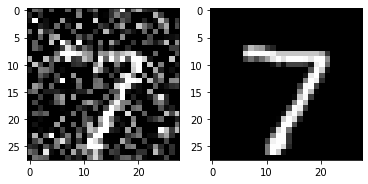

In [45]:
plt.subplot(121)
plt.imshow(test_set[0][0][0], cmap='gray')
plt.subplot(122)
plt.imshow(test_set[0][1][0], cmap='gray')

In [105]:
def train(model, trainset, testset):
    # Run model on cuda
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

    model.train()
    model.to(device)

    train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
    test_loader = DataLoader(testset, batch_size=128, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(10):
        model.train()
        train_loss = []
        for img, labels in train_loader:
            img, labels = img.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())

        val_loss = []
        noisy = None
        label = None
        denoised = None
        with torch.no_grad():
            model.eval()
            
            for img, labels in test_loader:
                img, labels = img.to(device), labels.to(device)
                
                output = model(img)
                loss = criterion(output, labels)
                val_loss.append(loss.item())
                
            noisy, label = testset[0]
            denoised = model(noisy.to(device)).detach().cpu()
    
        print("Epoch {} Train Loss {:.2f} Test Loss {:.2f}".format(epoch, np.mean(train_loss), np.mean(val_loss)))
        plt.subplot(131)
        plt.title("Noisy")
        plt.imshow(noisy[0], cmap='gray')
        plt.subplot(132)
        plt.title("Denoised")
        plt.imshow(denoised[0], cmap='gray')
        plt.subplot(133)
        plt.title("GT")
        plt.imshow(label[0], cmap='gray')
        plt.show()

In [106]:
model = MNISTDenoiser()

In [107]:
summary(model, input_data=torch.randn(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MNISTDenoiser                            --                        --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 32, 14, 14]           9,248
├─MaxPool2d: 1-4                         [1, 32, 7, 7]             --
├─ConvTranspose2d: 1-5                   [1, 32, 14, 14]           9,248
├─ConvTranspose2d: 1-6                   [1, 32, 28, 28]           9,248
├─Conv2d: 1-7                            [1, 1, 28, 28]            289
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
Total mult-adds (M): 11.35
Input size (MB): 0.00
Forward/backward pass size (MB): 0.51
Params size (MB): 0.11
Estimated Total Size (MB): 0.62

Using device: cuda
Epoch 0 Train Loss 0.11 Test Loss 0.05


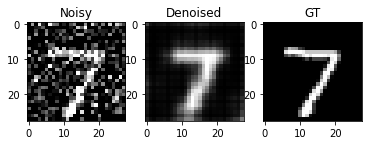

Epoch 1 Train Loss 0.04 Test Loss 0.02


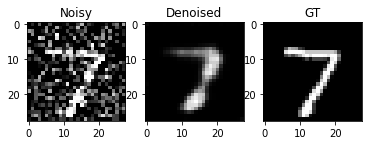

Epoch 2 Train Loss 0.02 Test Loss 0.02


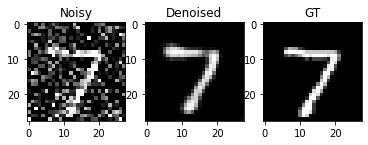

Epoch 3 Train Loss 0.02 Test Loss 0.01


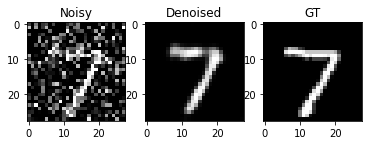

Epoch 4 Train Loss 0.01 Test Loss 0.01


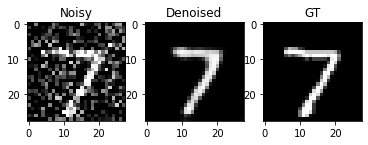

Epoch 5 Train Loss 0.01 Test Loss 0.01


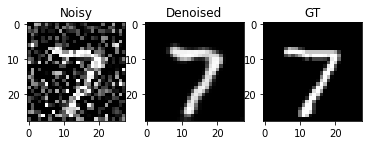

Epoch 6 Train Loss 0.01 Test Loss 0.01


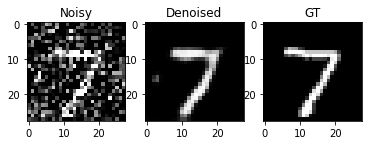

Epoch 7 Train Loss 0.01 Test Loss 0.01


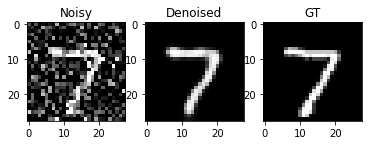

Epoch 8 Train Loss 0.01 Test Loss 0.01


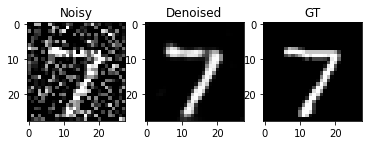

Epoch 9 Train Loss 0.01 Test Loss 0.01


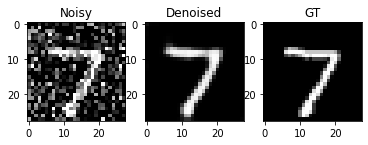

In [108]:
train(model, train_set, test_set)

## Saving model weights

In [109]:
torch.save(model.state_dict(), "model.pth")

In [111]:
state = torch.load("model.pth")

In [112]:
state.keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'upconv1.weight', 'upconv1.bias', 'upconv2.weight', 'upconv2.bias', 'conv3.weight', 'conv3.bias'])

In [154]:
for layer_name in state:
    data = state[layer_name].cpu().numpy()
    np.save(layer_name, data)

In [121]:
state['conv1.weight'].shape

torch.Size([32, 1, 3, 3])

In [120]:
state['conv2.weight'].shape

torch.Size([32, 32, 3, 3])

In [122]:
state['conv3.weight'].shape

torch.Size([1, 32, 3, 3])

## Testing

In [129]:
in_img = test_set[0][0]

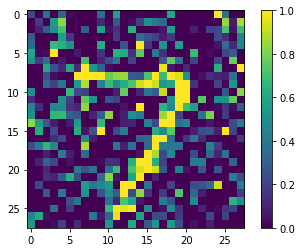

In [132]:
plt.imshow(in_img[0])
plt.colorbar()

In [135]:
out_img, lay_out = model(in_img.to('cuda'), True)

/home/ayakovenko/anaconda3/envs/yds/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [152]:
np.save("img.npy", in_img.numpy())

In [140]:
out_img = out_img.detach().cpu()
lay_out = [l.detach().cpu() for l in lay_out]

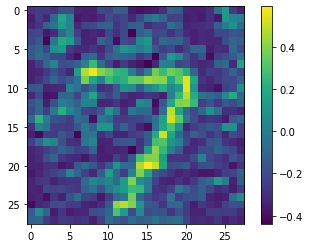

In [234]:
plt.imshow(lay_out[0][10])
plt.colorbar()

In [165]:
np.load('./libnpy/tests/data/empty_f4.npy')

array([], shape=(2, 0), dtype=float32)

In [320]:
out1 = np.load('./0_conv1.npy')

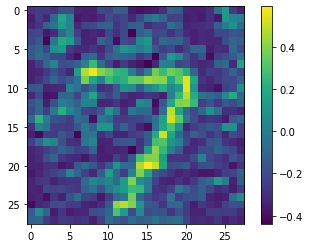

In [321]:
plt.imshow(out1[10])
plt.colorbar()

In [322]:
np.mean(lay_out[0].numpy() - out1)

1.1404135e-09

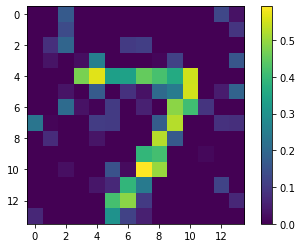

In [323]:
plt.imshow(lay_out[1][10])
plt.colorbar()

In [324]:
maxp1 = np.load('./1_maxpool1.npy')

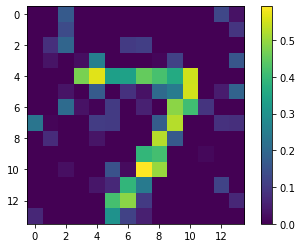

In [325]:
plt.imshow(maxp1[10])
plt.colorbar()

In [326]:
np.mean(lay_out[1].numpy() - maxp1)

2.4367033e-10

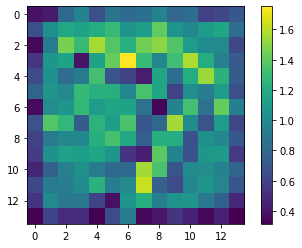

In [327]:
plt.imshow(lay_out[2][10])
plt.colorbar()

In [328]:
out2 = np.load('./2_conv2.npy')

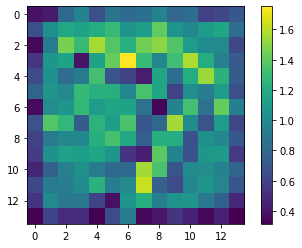

In [329]:
plt.imshow(out2[10])
plt.colorbar()

In [330]:
np.mean(lay_out[2].numpy() - out2)

-7.927824e-10

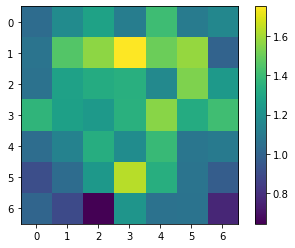

In [331]:
plt.imshow(lay_out[3][10])
plt.colorbar()

In [332]:
maxp2 = np.load('./3_maxpool2.npy')

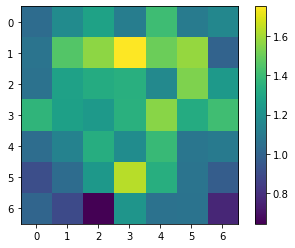

In [333]:
plt.imshow(maxp2[10])
plt.colorbar()

In [334]:
np.mean(lay_out[3].numpy() - maxp2)

1.14621574e-08

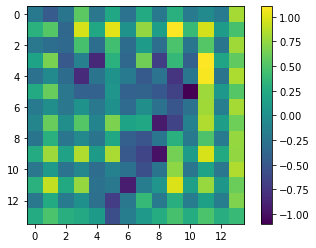

In [335]:
plt.imshow(lay_out[4][10])
plt.colorbar()

In [336]:
upconv1 = np.load('./4_upconv1.npy')

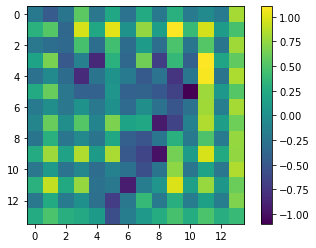

In [337]:
plt.imshow(upconv1[10])
plt.colorbar()

In [338]:
np.mean(lay_out[4].numpy() - upconv1)

1.5602623e-08

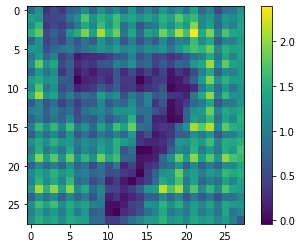

In [339]:
plt.imshow(lay_out[5][10])
plt.colorbar()

In [340]:
upconv2 = np.load('./5_upconv2.npy')

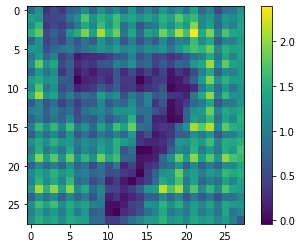

In [341]:
plt.imshow(upconv2[10])
plt.colorbar()

In [342]:
np.mean(lay_out[5].numpy() - upconv2)

2.2745729e-08

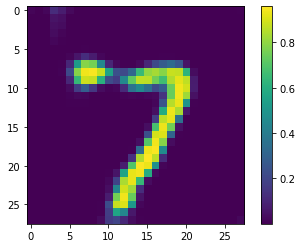

In [346]:
plt.imshow(out_img[0])
plt.colorbar()

In [350]:
conv3 = np.load('./out.npy')

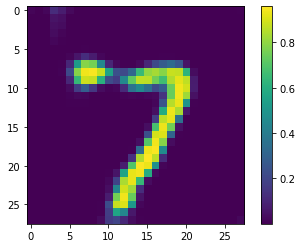

In [351]:
plt.imshow(conv3[0])
plt.colorbar()

In [352]:
np.mean(out_img.numpy() - conv3)

7.4448305e-09

## Testing high resolution
Upscaling MNIST up to 256 pixels high and wide

In [398]:
large_image_transforms = Compose([
    ToTensor(),
    Resize((256, 256)),
    Lambda(add_noise)
])

large_label_transforms = Compose([
    ToTensor(),
    Resize((256, 256)),
])

In [354]:
large_train_set = NoisyMNIST(True, large_image_transforms, large_label_transforms)
large_test_set = NoisyMNIST(False, large_image_transforms, large_label_transforms)

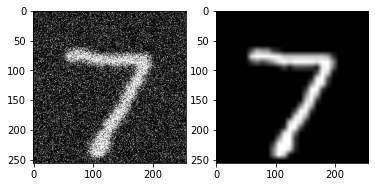

In [362]:
plt.subplot(121)
plt.imshow(large_test_set[0][0][0], cmap='gray')
plt.subplot(122)
plt.imshow(large_test_set[0][1][0], cmap='gray')

In [367]:
in_img = large_test_set[0][0]

In [372]:
np.save("img_256.npy", in_img.numpy())

In [368]:
t = model(in_img.to('cuda'))

In [369]:
o = t.detach().cpu()

In [370]:
o.shape

torch.Size([1, 256, 256])

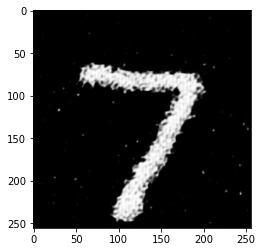

In [371]:
plt.imshow(o[0], cmap='gray')

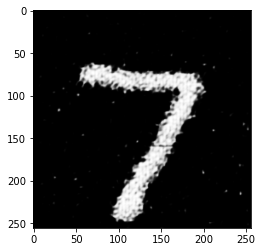

In [378]:
plt.imshow(np.load('out.npy')[0], cmap='gray')

In [ ]:
o[0]-np.load('out.npy')[0]

## Saving test images

In [379]:
from skimage.io import imsave

In [399]:
dataset = MNIST('./train_data/', transform=image_transforms)
large_dataset = MNIST('./train_data/', transform=large_image_transforms)

In [403]:
mask = [False] * 10

for (image, label), (large_image, _) in zip(dataset, large_dataset):
    if not mask[label]:
        mask[label] = True
        imsave(f"./test_images/{label}_small.png", image.numpy()[0])
        imsave(f"./test_images/{label}_big.png", large_image.numpy()[0])

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0